<a href="https://colab.research.google.com/github/abhisheshgupta/Car_vs_Bike_Image_Classification/blob/main/Car_Vs_Bike_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
#importing required libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers

#Get the Data

In [ ]:
import os

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

###Raw Data Download

In [ ]:
!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset

 98% 101M/103M [00:06<00:00, 25.4MB/s] 
100% 103M/103M [00:06<00:00, 16.7MB/s]


In [ ]:
!unzip /content/car-vs-bike-classification-dataset.zip

Archive:  /content/car-vs-bike-classification-dataset.zip
  inflating: Car-Bike-Dataset/Bike/Bike (1).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1).jpg  
  inflating: Car-Bike-Dataset/Bike/Bike (1).png  
  inflating: Car-Bike-Dataset/Bike/Bike (10).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (10).jpg  
  inflating: Car-Bike-Dataset/Bike/Bike (10).png  
  inflating: Car-Bike-Dataset/Bike/Bike (100).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (100).jpg  
  inflating: Car-Bike-Dataset/Bike/Bike (1000).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1001).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1002).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1003).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1004).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1005).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1006).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1007).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1008).jpeg  
  inflating: Car-Bike-Dataset/Bike/Bike (1009)

###fiter out corrupt images

In [ ]:
#filering corrupt images
num_skipped = 0
for folder_name in ("Bike", "Car"):
    folder_path = os.path.join("output/train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 47 images


#Generate a dataset

In [ ]:
#generate a training data
image_size = (180, 180)
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    "output/train",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2753 files belonging to 2 classes.


In [ ]:
#generate a validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    "output/val",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 800 files belonging to 2 classes.


#visualize tha data

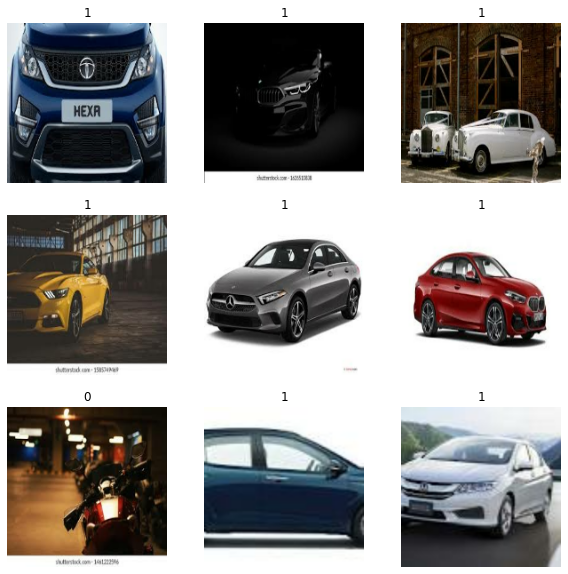

In [ ]:
#visualize the training data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

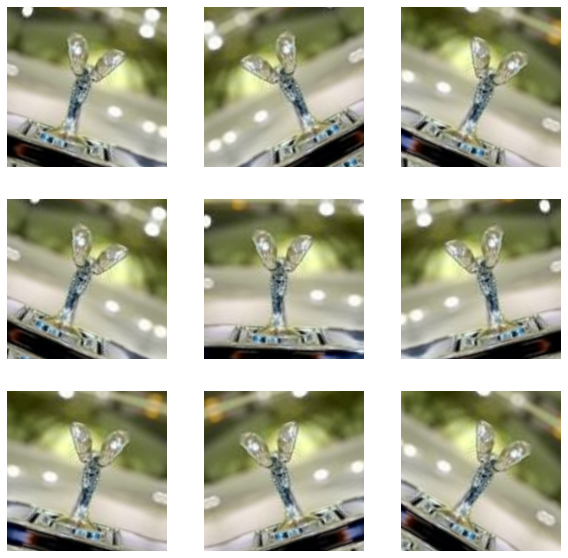

In [ ]:
#visualize augmented data
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

###configure the dataset for performance

In [ ]:
# Apply data_augmentation to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

#Build a Model

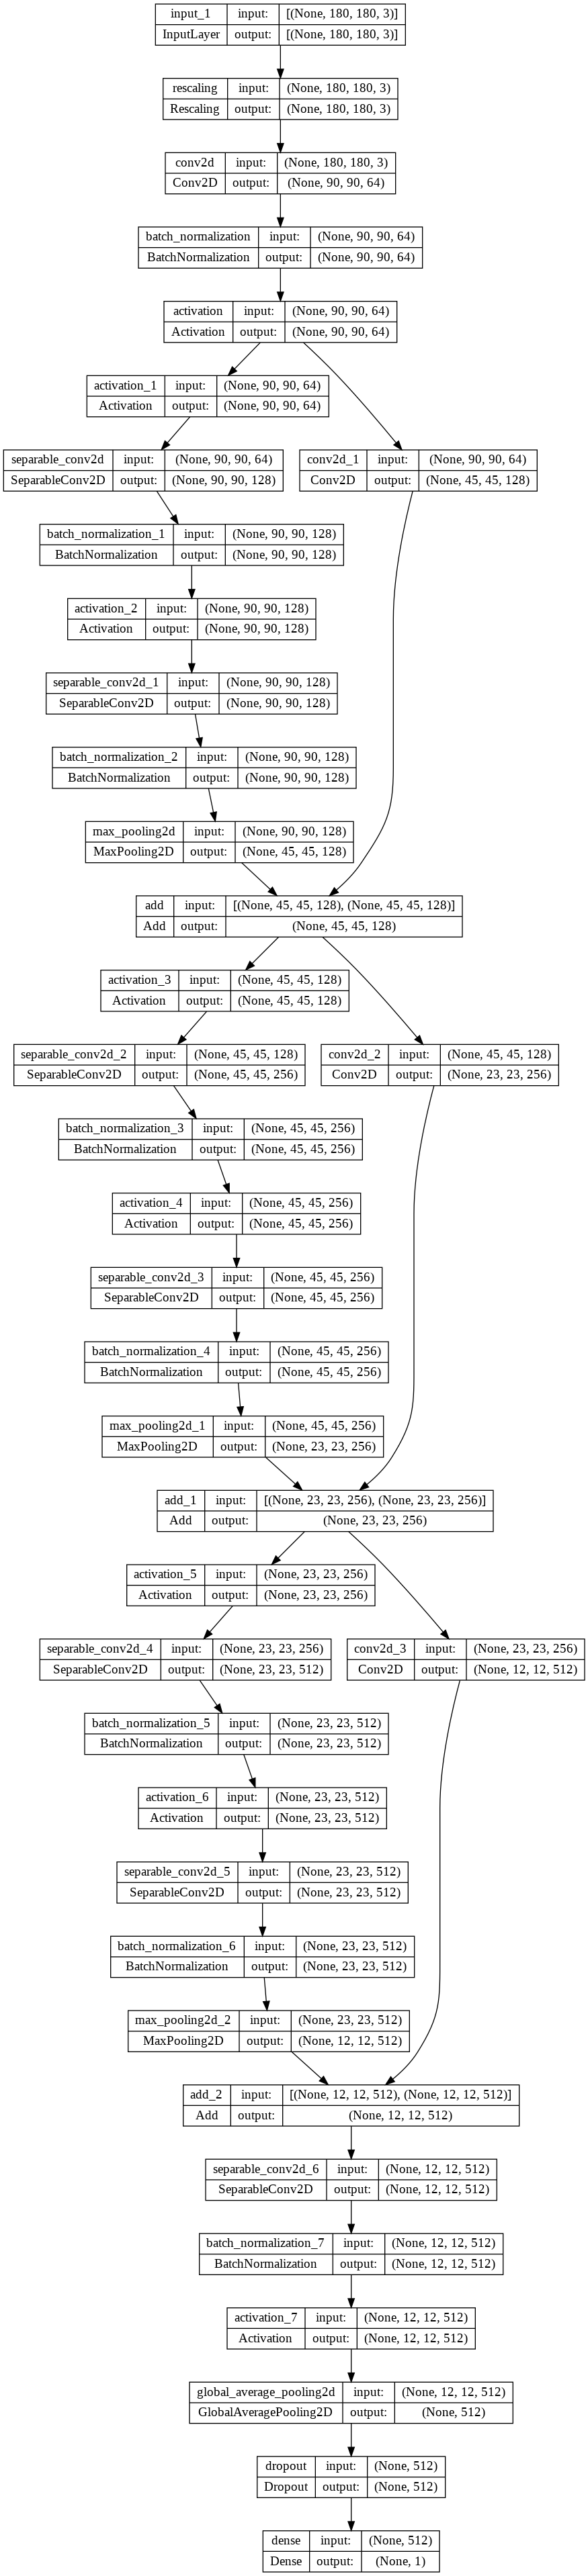

In [ ]:
#defining a model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(512, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

#Train the Model

In [ ]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras",save_best_only = True),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/15
44/44 [==============================] - 45s 720ms/step - loss: 0.5827 - accuracy: 0.7207 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 2/15
44/44 [==============================] - 34s 748ms/step - loss: 0.3804 - accuracy: 0.8453 - val_loss: 0.6997 - val_accuracy: 0.5000
Epoch 3/15
44/44 [==============================] - 35s 773ms/step - loss: 0.3330 - accuracy: 0.8652 - val_loss: 0.7119 - val_accuracy: 0.5000
Epoch 4/15
44/44 [==============================] - 34s 734ms/step - loss: 0.2642 - accuracy: 0.9023 - val_loss: 0.7310 - val_accuracy: 0.5000
Epoch 5/15
44/44 [==============================] - 35s 757ms/step - loss: 0.2259 - accuracy: 0.9125 - val_loss: 0.7212 - val_accuracy: 0.5000
Epoch 6/15
44/44 [==============================] - 34s 743ms/step - loss: 0.2287 - accuracy: 0.9096 - val_loss: 0.7225 - val_accuracy: 0.5000
Epoch 7/15
44/44 [==============================] - 33s 723ms/step - loss: 0.1845 - accuracy: 0.9241 - val_loss: 0.6926 - val_accuracy: 0.5000

#Run inference on new data

In [ ]:
img1 = keras.preprocessing.image.load_img(
    "/content/output/test/Car/Car (1027).jpeg", target_size=image_size
)
img_array1 = keras.preprocessing.image.img_to_array(img1)
img_array1 = tf.expand_dims(img_array1, 0)  # Create batch axis

predictions1 = model.predict(img_array1)
score1 = float(predictions1[0])
print(f"This image is {100 * (1 - score1):.2f}% bike and {100 * score1:.2f}% car.")

1/1 [==============================] - 1s 735ms/step
This image is 7.42% bike and 92.58% car.


In [ ]:
img2 = keras.preprocessing.image.load_img(
    "/content/output/test/Car/Car (1018).jpeg", target_size=image_size
)
img_array2 = keras.preprocessing.image.img_to_array(img2)
img_array2 = tf.expand_dims(img_array2, 0)  # Create batch axis

predictions2 = model.predict(img_array2)
score2 = float(predictions2[0])
print(f"This image is {100 * (1 - score2):.2f}% bike and {100 * score2:.2f}% car.")

1/1 [==============================] - 0s 17ms/step
This image is 0.87% bike and 99.13% car.


In [ ]:
img3 = keras.preprocessing.image.load_img(
    "/content/output/test/Bike/Bike (1024).jpeg", target_size=image_size
)
img_array3 = keras.preprocessing.image.img_to_array(img3)
img_array3 = tf.expand_dims(img_array3, 0)  # Create batch axis

predictions3 = model.predict(img_array3)
score3 = float(predictions3[0])
print(f"This image is {100 * (1 - score3):.2f}% bike and {100 * score3:.2f}% car.")

1/1 [==============================] - 0s 17ms/step
This image is 86.92% bike and 13.08% car.


In [ ]:
img4 = keras.preprocessing.image.load_img(
    "/content/output/test/Bike/Bike (1015).jpeg", target_size=image_size
)
img_array4 = keras.preprocessing.image.img_to_array(img4)
img_array4 = tf.expand_dims(img_array4, 0)  # Create batch axis

predictions4 = model.predict(img_array4)
score4 = float(predictions4[0])
print(f"This image is {100 * (1 - score4):.2f}% bike and {100 * score4:.2f}% car.")

1/1 [==============================] - 0s 28ms/step
This image is 74.04% bike and 25.96% car.
